In [1]:
# %pip install pwlf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import pwlf

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import r2_score

from scipy.optimize import nnls, lsq_linear, least_squares
from scipy.interpolate import splev, splrep

%matplotlib inline

In [3]:
# random state
rs = 4

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [4]:
from lib.data.nations import cc_dict, pop_dict

for c, p in zip(cc_dict.values(), pop_dict.values()):
    print(f'{c:10}', ':', p)

Argentina  : 45195774
Australia  : 25499884
China      : 1439323776
Czechia    : 10708981
Egypt      : 102334404
Finland    : 5540720
Honduras   : 9904607
India      : 1380004385
Japan      : 126476461
Norway     : 5421241
Russia     : 145934462
Sweden     : 10099265
Thailand   : 69799978
US         : 331002651


## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [5]:
from lib.data.cases import jhu_cases, jhu_death, jhu_recov

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (610, 198)
deaths shape: (610, 198)
recoveries shape: (610, 198)


To ensure the smoothness of the data, **rolling average** is applied.

In [6]:
from lib.data.cases import window, cum_cases, cum_deaths, cum_recoveries

Use it to compute further variables (compartments) needed to represent the compartmental model.

In [7]:
R = cum_deaths + cum_recoveries
I = cum_cases - R
S = pop_dict.values() - cum_cases

In [8]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [9]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0

In [10]:
gr = log_i[1:] - log_i[:-1].values # different index

### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$. An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [11]:
# dr_dt = r_prop[1:] - r_prop[:-1].values # different index
# gamma = dr_dt / i_prop[1:]
# gamma[np.isinf(gamma)] = np.nan # division by zero
# gamma[gamma.isna()] = 0         # before the pandemic begins
# beta = (gr + gamma) / s_prop[1:]

In [12]:
# the alternative formula
log_s = np.log(S)
diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
beta = diff_log / I

## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment and some health system-related measures are considered.

In [13]:
from lib.data.policies import oxcgrt, oxcgrt_sub

C:\Users\ALEJAN~1\AppData\Local\Temp/ipykernel_17260/2426111546.py:1: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  from lib.data.policies import oxcgrt, oxcgrt_sub


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [14]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-09-22 00:00:00
Policy data: 2020-01-01 00:00:00 - 2022-03-14 00:00:00


After some manipulation, it is possible to obtain a different table per policy type.

In [15]:
from lib.data.policies import CH_X, idch
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

# Model

Development of the model(s) and results.

## Auxiliar

In [16]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

from lib.helper import chx_str

In [17]:
# aux fns
from lib.helper import _get_init_date, _print_model, std_err

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: specific for each of the two label types
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)

  # label = pd.Series(y_norm[1:], index=y_t[1:].index) # date ref
  
  return df, y_norm[1:]

## Initial model

Uses the groth rate, $gr=\beta-\gamma$, as label. Conditioned on the restriction $s\rightarrow1$, it reaches a different time range depending on the country.

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [18]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-5.75818558e+24,  8.24212569e-01, -1.23068489e+26, -1.07103125e+25,
        7.59325332e-01, -1.16715281e+25,  8.17134482e-01,  7.85442191e-01,
        7.98626774e-01,  7.57453482e-01, -4.65754188e+23, -2.52333589e+24,
       -2.50553075e+24,  8.08728546e-01,  7.60929520e-01, -7.42690840e+24,
       -8.28025011e+23,  7.87225626e-01,  8.11003270e-01,  7.66611455e-01,
       -1.30030910e+24, -8.81755581e+24, -6.02927344e+23,  8.11938638e-01,
       -2.39473059e+22])

In [19]:
cv_arr.mean()

-7.028112362878924e+24

In [20]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.83980461, 0.80723293, 0.77197324, 0.78865612, 0.75647094,
       0.85068766, 0.81959493, 0.78104566, 0.79504145, 0.75968492,
       0.84123059, 0.81051732, 0.76680201, 0.78659676, 0.75173442,
       0.8429878 , 0.8135263 , 0.7672435 , 0.7871562 , 0.75127139,
       0.84656415, 0.81588612, 0.7712851 , 0.79038729, 0.75651266])

In [21]:
cv_arr.mean()

0.794795761805277

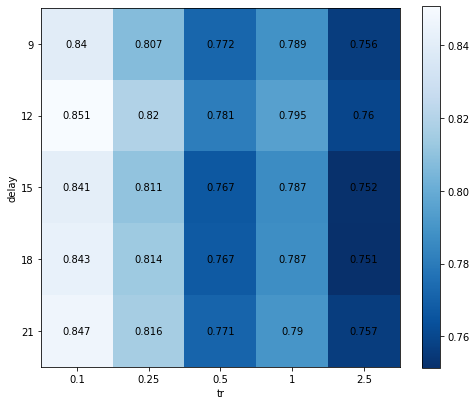

In [22]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [23]:
def initial_model(region, tr=1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [24]:
coef, r_sq = [], []
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = initial_model(k)
  coef.append(m_k.coef_[:-1])
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameteres.

In [25]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.7612179120406922 0.1102991300870692


In [26]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.78	0.93	0.59	0.98	0.37	0.9	0.96	0.97	0.88	-0.26	0.97	0.97	0.66	0.96	

Global effect of each policy.

In [27]:
coef = np.asarray(coef)
mu_coef = coef.mean(axis=0)
for string, value in zip(idch, mu_coef):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.012652
Workplace closing                 -> -0.002212
Cancel public events              -> -0.015873
Restrictions on gatherings        -> -0.017518
Close public transport            -> 0.000811
Stay at home requirements         -> 0.001665
Restrictions on internal movement -> -0.002380
International travel controls     -> 0.000869
Public information campaigns      -> -0.014827
Facial Coverings                  -> -0.007482


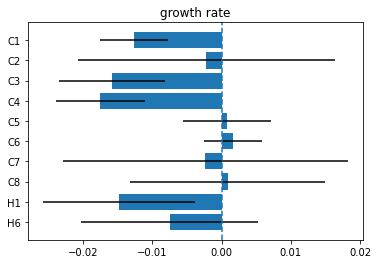

In [28]:
err_coef = std_err(coef)

plt.barh(chx_str[::-1], mu_coef[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('growth rate')
plt.show()

In [29]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of the model for one country.

In [30]:
idx = -1 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.087005
C2 : -0.001721
C4 : -0.067872
C5 : -0.011398
C6 : -0.007894
C8 : -0.009851
H1 : -0.006011
H6 : -0.030896
prev : 0.689391

R^2
---
0.961


Visual representation of the model.

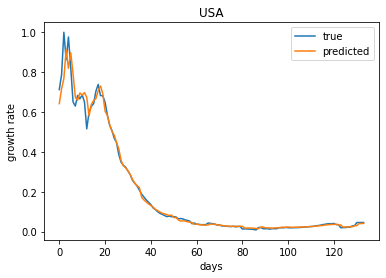

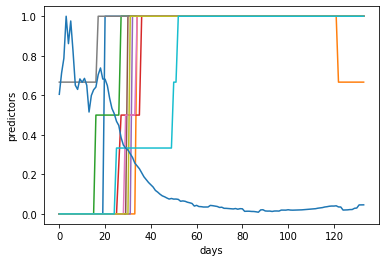


Number of data points: 134
Number of variables: 11


In [31]:
model, X, y = initial_model(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.xlabel('days')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.xlabel('days')
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

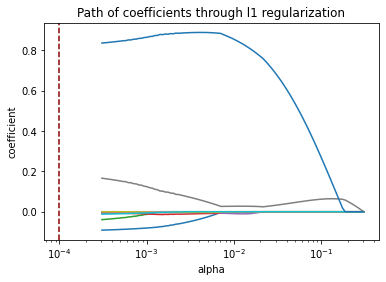

In [32]:
alphas, coefs = model.path(X, y)[:2]
alpha = model.get_params()['alpha']
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(alpha, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

## Transmission model

It uses the transmission rate, $\beta$, as label. The linear function is fitted in thiner time segments.

Parameter grid search.

In [33]:
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [34]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.91911728e-01,  8.89290063e-01,  8.88338769e-01,  8.91406019e-01,
       -1.14798268e+20,  8.88530011e-01,  8.87196565e-01,  8.89062541e-01,
        8.83095251e-01,  8.87847580e-01,  8.87945551e-01,  8.87720847e-01,
        8.86884903e-01,  8.87093306e-01])

In [35]:
cv_arr.mean()

-8.199876297068801e+18

In [36]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.89346958, 0.896986  , 0.89152943, 0.89254809, 0.8954706 ,
       0.89183794, 0.89058659, 0.88780195, 0.887123  , 0.8885055 ,
       0.88585147, 0.88490959, 0.88614773, 0.88701567, 0.88394229,
       0.88506942, 0.88726699, 0.88987148, 0.88708595, 0.89006309])

In [37]:
cv_arr.mean()

0.8891541174037985

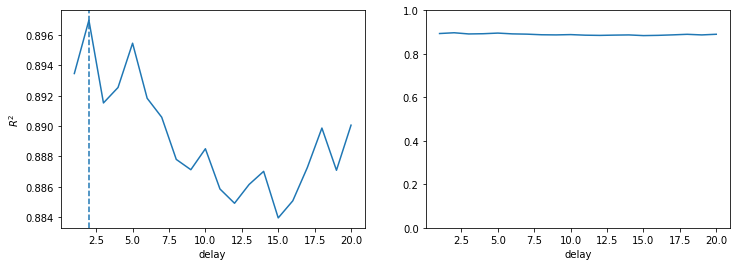

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [39]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, reg, score, coef_values = [], [], [], [], []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [40]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = [lasso.coef_[:-1] for lasso in m_k]
  coef_glob.append(np.asarray(coef_k).mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))                    # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [41]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9193279072028143 0.004918039417220929


In [42]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.95	0.92	0.94	0.98	0.96	0.76	0.94	0.93	0.96	0.98	0.97	0.76	0.97	

*Global* values for the coefficients of each policy type.

In [43]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.002415
Workplace closing                 -> -0.001426
Cancel public events              -> -0.001751
Restrictions on gatherings        -> -0.006746
Close public transport            -> -0.002976
Stay at home requirements         -> -0.005115
Restrictions on internal movement -> 0.003857
International travel controls     -> 0.000111
Public information campaigns      -> -0.000690
Facial Coverings                  -> -0.001418


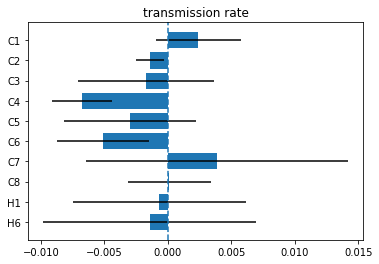

In [44]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

*Interval*-wise values for the coefficients of each policy type. They are meant to represent the coefficients at different stages of the pandemic.

In [45]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [46]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


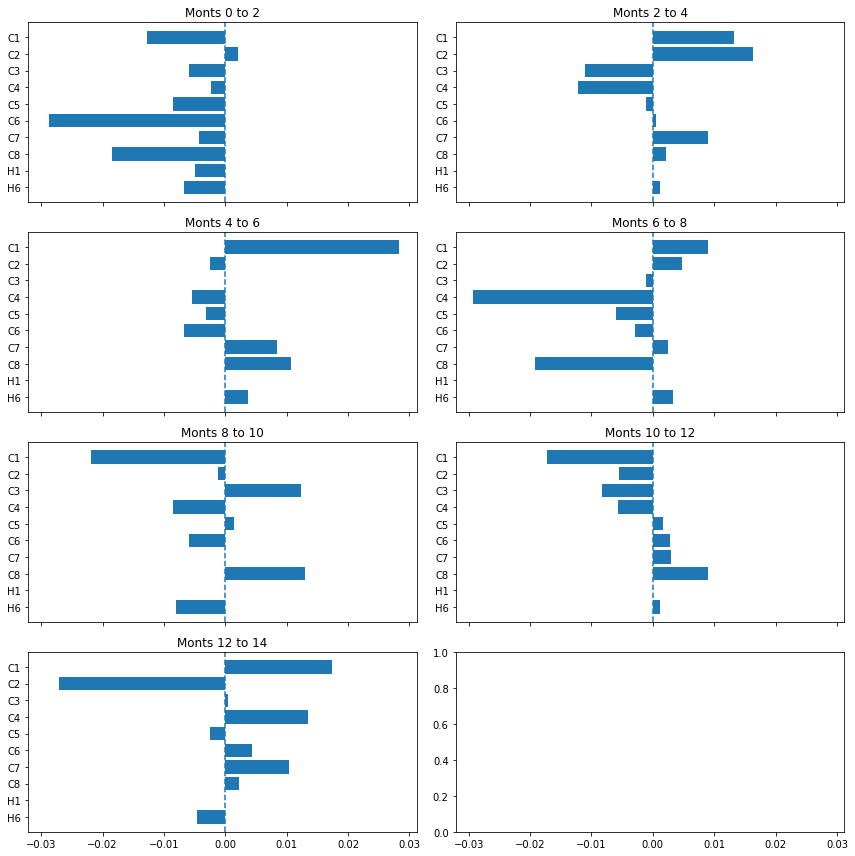

In [47]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

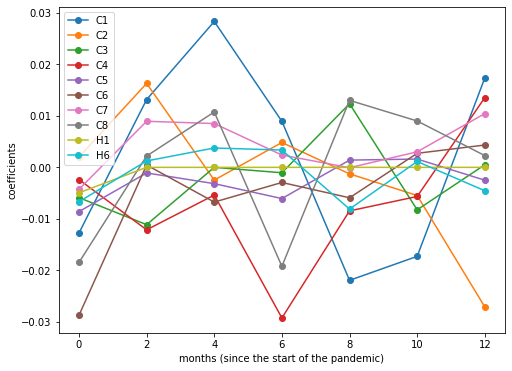

In [48]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

In [49]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of single country model.

In [50]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.019574
C2 : -0.005698
C3 : -0.018805
C4 : -0.005817
C5 : 0.004853
C6 : 0.006201
C7 : 0.016214
C8 : 0.000188
H1 : -0.001496
prev : 0.838226

R^2
---
0.761


Resulting predictions of the model.

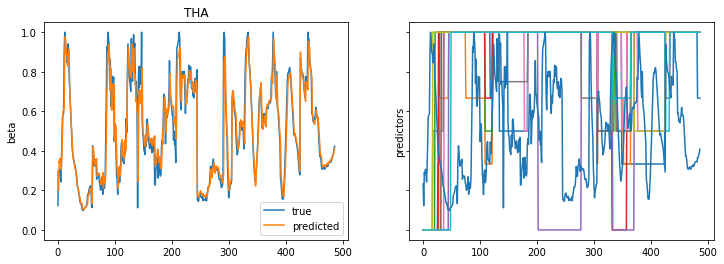

In [51]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

## Constrained model

Uses the transmission rate, $\beta$, as label. The coefficients (in every segment) are forced to take negative values.

### Non-negative least squares

This is achieved by reversing the sign of the coefficients, $\theta$, and imposing a positive constrain, namely $\theta \ge 0$.

Parameter grid search.

In [52]:
y_df = -beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = nnls(X.iloc[train_idx], y[train_idx])[0]
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.88734476, 0.88722834, 0.88719599, 0.8872913 , 0.88734764,
       0.88739863, 0.88716536, 0.88706114, 0.88706959, 0.88683639,
       0.88684101, 0.8868377 , 0.88679753, 0.88676169, 0.8868553 ,
       0.88657152, 0.88674478, 0.88690651, 0.88691691, 0.88722983])

In [53]:
cv_arr.mean()

0.8870200964486973

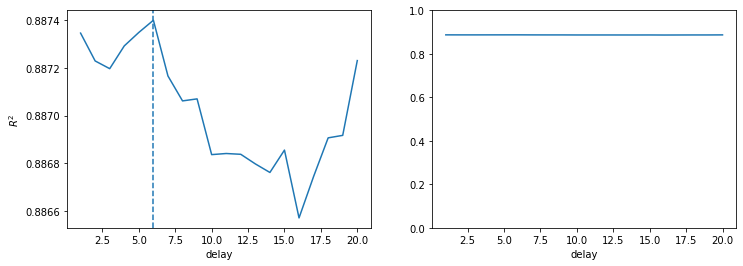

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [55]:
def nnls_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, -beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = nnls(X_train, y_train)[0]

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [56]:
coef_glob, coef_intv , r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = nnls_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [57]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9130325409009254 0.005573691982951899


In [58]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.91	0.93	0.97	0.95	0.73	0.95	0.92	0.95	0.98	0.97	0.76	0.96	

*Global* values for the coefficients of each policy type.

In [59]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.001284
Workplace closing                 -> 0.003825
Cancel public events              -> 0.000653
Restrictions on gatherings        -> 0.001956
Close public transport            -> 0.000564
Stay at home requirements         -> 0.001532
Restrictions on internal movement -> 0.000969
International travel controls     -> 0.000877
Public information campaigns      -> 0.000172
Facial Coverings                  -> 0.000467


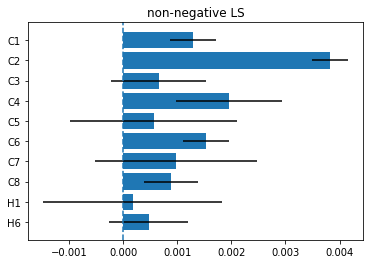

In [60]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('non-negative LS')
plt.show()

### Linear least-squares with bounds

This optimization problem is convex, hence a found **minimum** (if iterations have converged) is guaranteed to be **global**.

In [61]:
# bound policy coefficients (only)
bounds = (-np.inf, [0] * len(chx_str) + [np.inf])

In [62]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = lsq_linear(X.iloc[train_idx], y[train_idx], bounds)['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.86836172e-01,  8.86874676e-01,  8.87195853e-01,  8.87291305e-01,
        8.87022222e-01,  8.87398625e-01,  8.87165360e-01,  8.86906335e-01,
       -2.14574017e+15,  8.86839379e-01,  8.86840633e-01,  8.86837708e-01,
        8.86798990e-01,  8.86761747e-01,  8.86855302e-01,  8.86573052e-01,
        8.86744772e-01,  8.86794804e-01,  8.86919311e-01,  8.86649290e-01])

In [63]:
cv_arr.mean()

-107287008361347.8

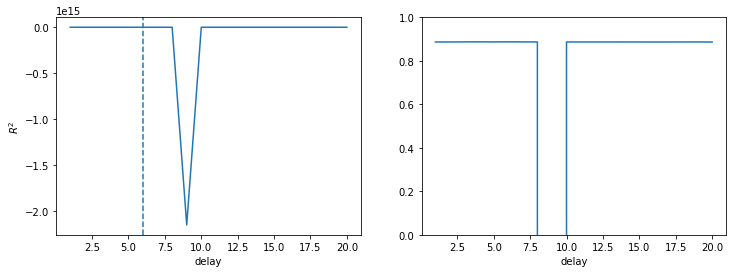

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [65]:
def lsq_linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [66]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = lsq_linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [67]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9130433839281075 0.0055748942503252435


In [68]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.91	0.93	0.97	0.95	0.73	0.95	0.92	0.95	0.98	0.97	0.76	0.96	

In [69]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002491
Workplace closing                 -> -0.002629
Cancel public events              -> -0.001512
Restrictions on gatherings        -> -0.006163
Close public transport            -> -0.025603
Stay at home requirements         -> -0.008823
Restrictions on internal movement -> -0.011419
International travel controls     -> -0.001131
Public information campaigns      -> -0.000519
Facial Coverings                  -> -0.010940


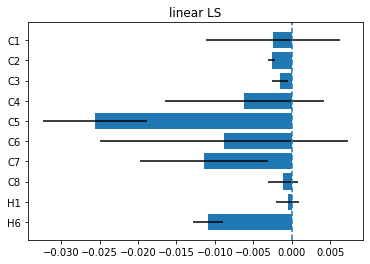

In [70]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('linear LS')
plt.show()

### Non-linear least-squares with bounds

Given the residuals `fun(x)` (an m-D real function of n real variables) and the (optional) loss function `rho(s)` (a scalar function), `least_squares` finds a **local minimum** of the cost function.

In [71]:
# initial guess on independent variables
x0 = [0] * len(chx_str) + [1]
# computes the vector of residuals
def fun(x, A, y):
  return A @ x - y

In [72]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = least_squares(
          fun, x0, bounds=bounds, args=(X.iloc[train_idx], y[train_idx])
      )['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.63094587, 0.79601309, 0.88719606, 0.8872914 , 0.82053204,
       0.88739852, 0.88716567, 0.8870623 , 0.883784  , 0.88683676,
       0.88684137, 0.88683851, 0.88679921, 0.88676189, 0.88685574,
       0.88657247, 0.88674483, 0.88682492, 0.88690818, 0.0170045 ])

In [73]:
cv_arr.mean()

0.8226188648895573

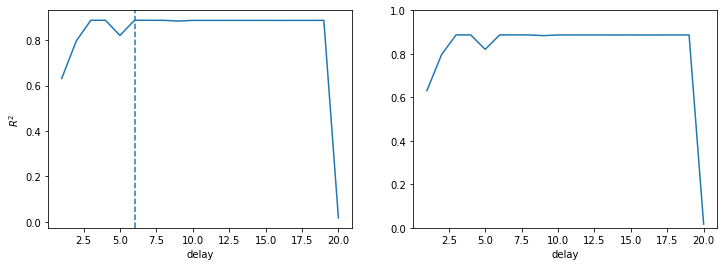

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [75]:
def least_squares_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = least_squares(fun, x0, bounds=bounds, args=(X_train, y_train))['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [76]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = least_squares_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [77]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9130328125769338 0.00557375707571713


In [78]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.001782
Workplace closing                 -> -0.002806
Cancel public events              -> -0.006560
Restrictions on gatherings        -> -0.207346
Close public transport            -> -0.678385
Stay at home requirements         -> -0.173579
Restrictions on internal movement -> -0.370901
International travel controls     -> -0.000995
Public information campaigns      -> -0.000358
Facial Coverings                  -> -0.023200


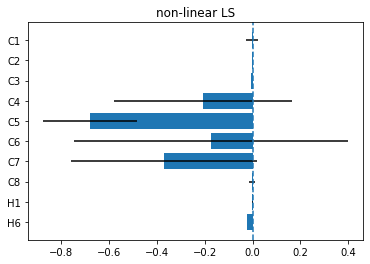

In [79]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('non-linear LS')
plt.show()

### Final constrained model

The linear least squares model makes use of the linear nature of the problem and gives a global solution without relying on a specific starting point, which proved to give skewed results (a lot of zero-valued coefficients). At the same time, the possibility of applying bounds makes it very flexible and allows to impose the constraints we are looking for ($\theta\le0$).

In [80]:
def constrained_model(region, delay=12, print=False, label=beta):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, label)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [81]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [82]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9130433839281075 0.0055748942503252435


In [83]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.91	0.93	0.97	0.95	0.73	0.95	0.92	0.95	0.98	0.97	0.76	0.96	

In [84]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002491
Workplace closing                 -> -0.002629
Cancel public events              -> -0.001512
Restrictions on gatherings        -> -0.006163
Close public transport            -> -0.025603
Stay at home requirements         -> -0.008823
Restrictions on internal movement -> -0.011419
International travel controls     -> -0.001131
Public information campaigns      -> -0.000519
Facial Coverings                  -> -0.010940


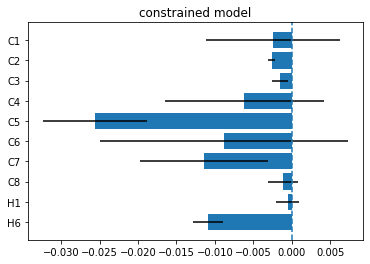

In [85]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('constrained model')
plt.show()

In [86]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [87]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
mu_coef_intv = coef_intv.mean(axis=0)
print(mu_coef_intv.shape)

(14, 8, 10)
(8, 10)


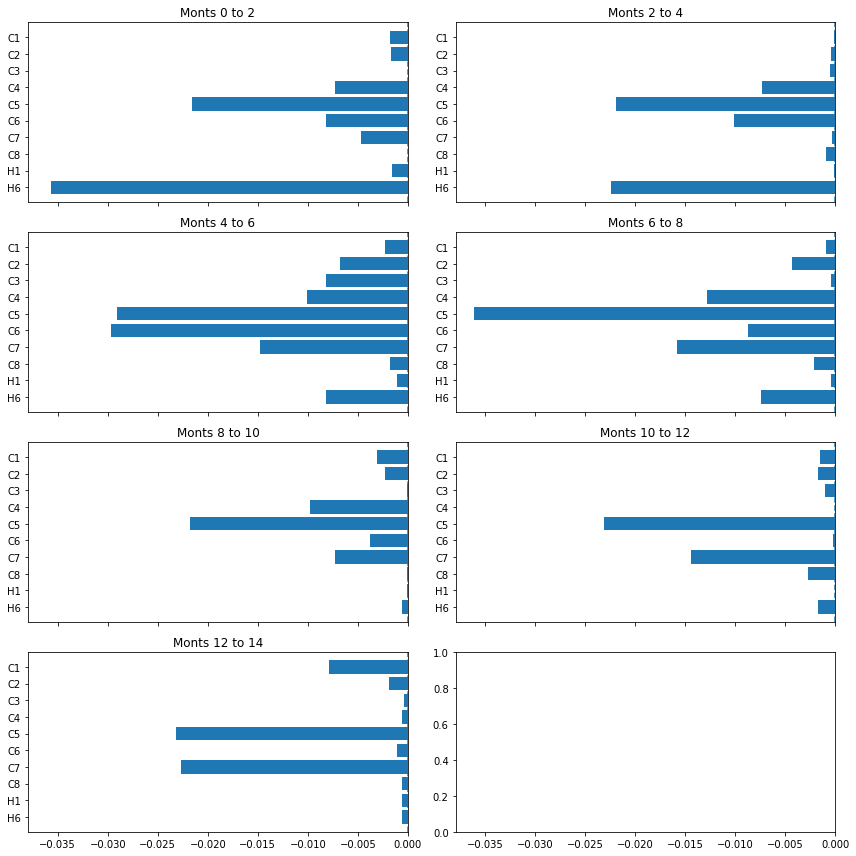

In [88]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in mu_coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

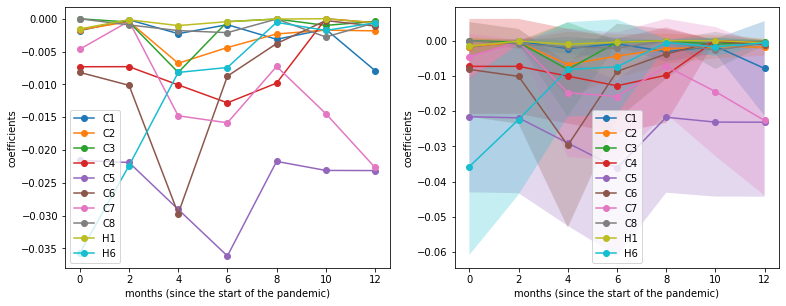

In [89]:
x = range(0, dim * 2, 2)
err = std_err(coef_intv)

size_ratio = 1
fig, axs = plt.subplots(ncols=2, figsize=[6.4*2*size_ratio, 4.8*size_ratio])
axs[0].plot(x, mu_coef_intv, 'o-')
axs[0].set_xlabel('months (since the start of the pandemic)')
axs[0].set_ylabel('coefficients')
axs[0].legend(chx_str)
axs[1].plot(x, mu_coef_intv, 'o-')
axs[1].set_xlabel('months (since the start of the pandemic)')
axs[1].set_ylabel('coefficients')
axs[1].legend(chx_str)
for i in range(mu_coef_intv.shape[1]):
  lberr = mu_coef_intv[:, i] - err[:, i]
  hberr = mu_coef_intv[:, i] + err[:, i]
  # axs[1].plot(x, mu_coef_intv[:, i])
  axs[1].fill_between(x, lberr, hberr, alpha=0.25)

# fig.show()

In [90]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


In [91]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.019574
C2 : -0.005698
C3 : -0.018805
C4 : -0.005817
C5 : 0.004853
C6 : 0.006201
C7 : 0.016214
C8 : 0.000188
H1 : -0.001496
prev : 0.838226

R^2
---
0.761


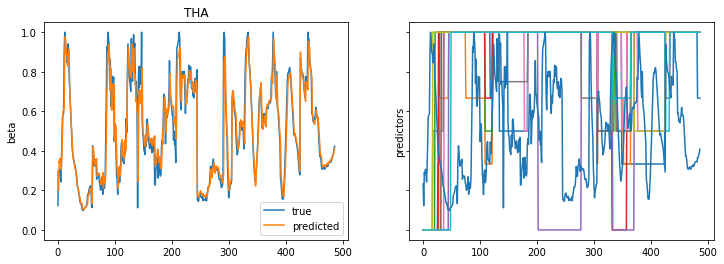

In [92]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

### Alternative beta definitions

The value of $β$ is not supposed to change rapidly over time (**careful with the meaning of $\beta$ in this model!**).
Two different strategies to assess the (moderate) changes in $\beta$ are:

* Smoothing $\beta$ over long periods of time (over a week).
* Computing piece-wise linear (B-splines) or piece-wise constant curves for $\beta$.



#### Smoothing

In [93]:
beta_smooth = beta.rolling(window=10, min_periods=1).mean()

In [94]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_smooth)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [95]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9797566993106203 0.00012740222278071766


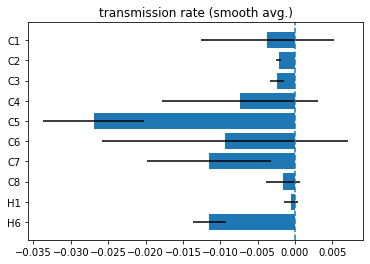

In [96]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.axvline(ls='--')
plt.title('transmission rate (smooth avg.)')
plt.show()

In [97]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [98]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


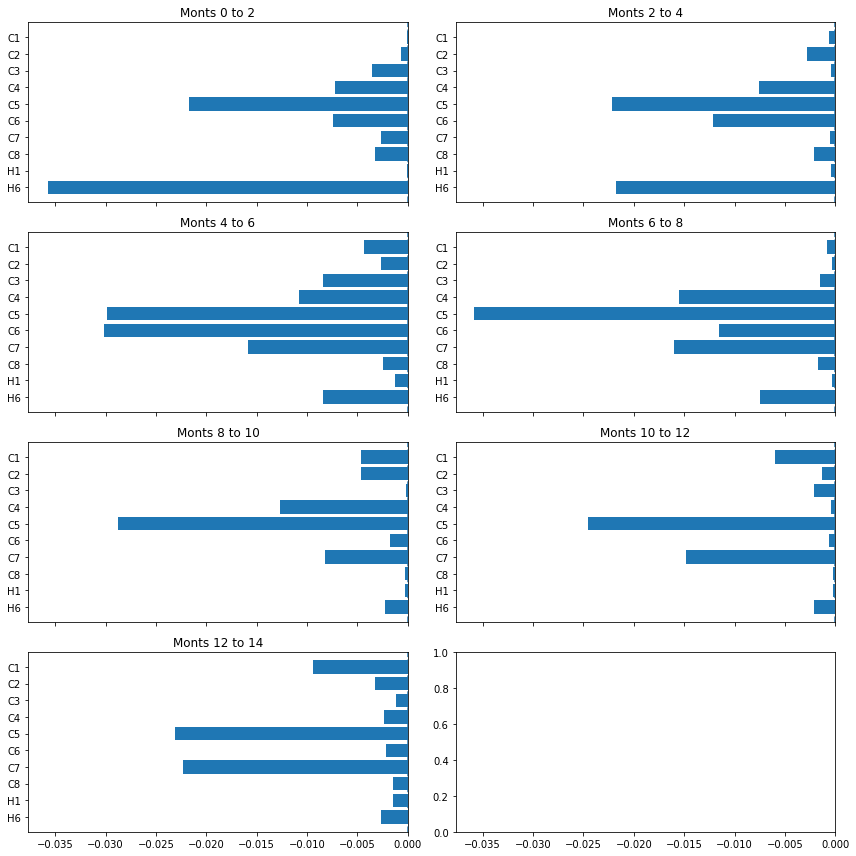

In [99]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

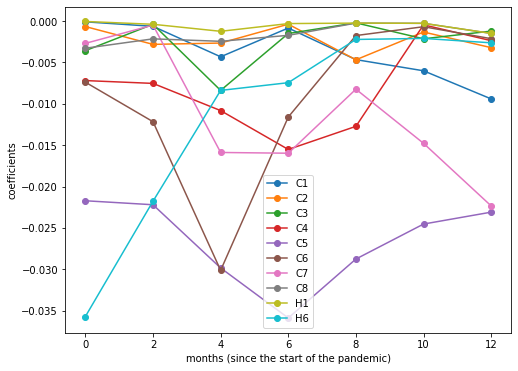

In [100]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Piece-wise constant

In [101]:
beta_rs = beta.resample('1M', label='left').mean()
beta_cst = beta_rs.resample('1d').pad()
beta_cst = beta_cst[ta:tb] # upsampling expands the date range

In [102]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_cst)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [103]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

-10.522653707131498 1205.9713207309069


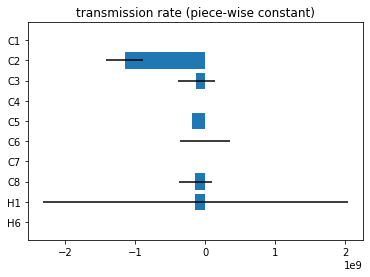

In [104]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.title('transmission rate (piece-wise constant)')
plt.show()

In [105]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [106]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


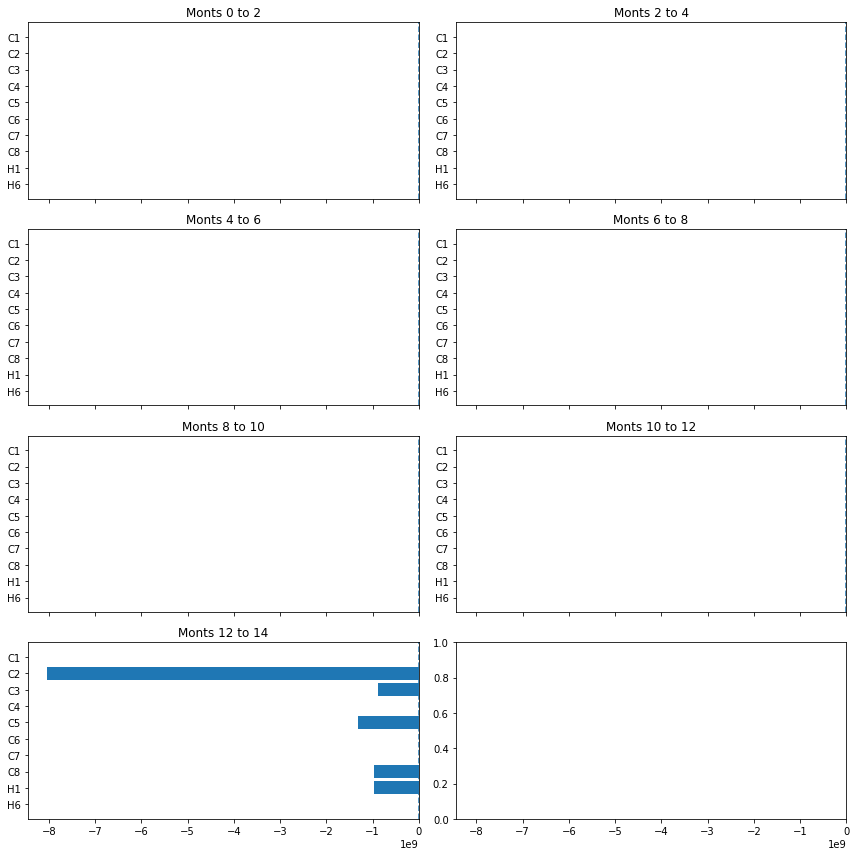

In [107]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

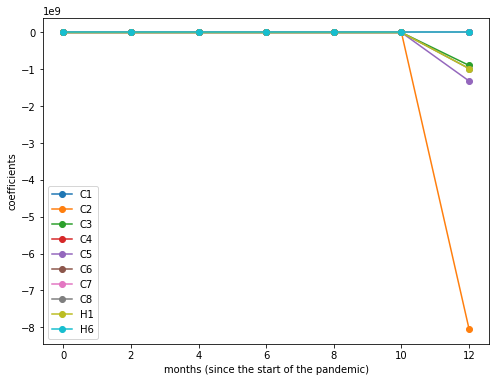

In [108]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Piece-wise linear

In [109]:
beta_lin = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta[cn]
  y[y.isna()] = 0

  n_pwlf = pwlf.PiecewiseLinFit(x, y)
  # can't control were the knots will be!
  knots = n_pwlf.fit(beta.shape[0] // 30) 
  beta_lin[cn] = n_pwlf.predict(x)

In [110]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_lin)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_lsq\trf_linear.py:117: RuntimeWarning: invalid value encountered in multiply
  r_h = p_h + r_h * r_stride


In [111]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9840698878238426 0.0002776205647753866


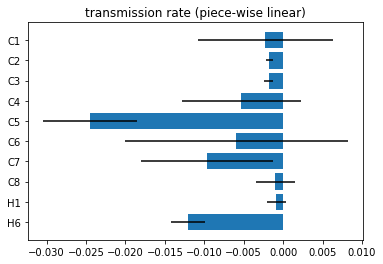

In [112]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.title('transmission rate (piece-wise linear)')
plt.show()

In [113]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [114]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


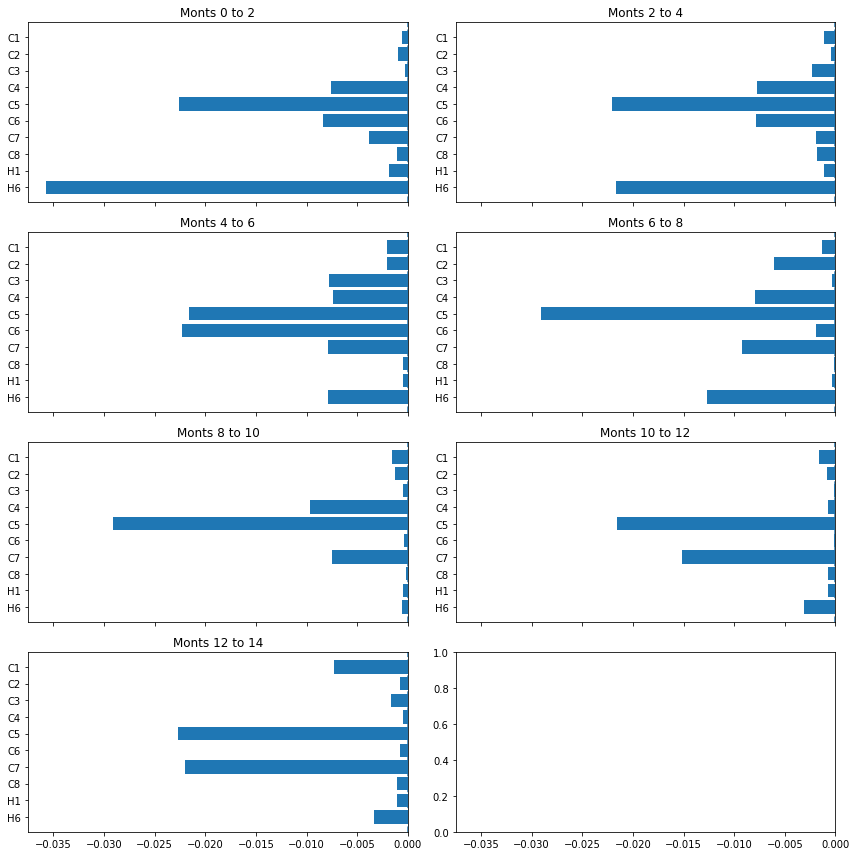

In [115]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

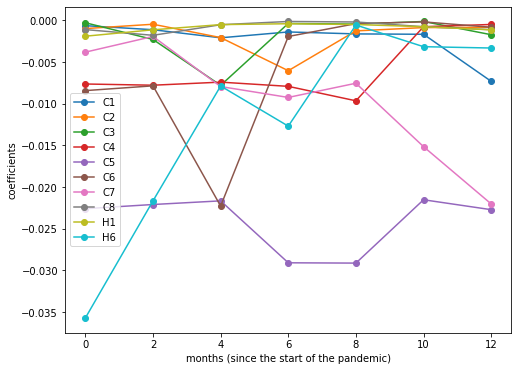

In [116]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Cubic splines

In [117]:
beta_spl = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta_rs[cn]
  y[y.isna()] = 0
  knots = np.asarray(range(len(y))) * 30

  spl = splrep(knots, y)       # representation
  beta_spl[cn] = splev(x, spl) # evaluation

In [118]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_spl)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [119]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9946392289018972 2.1536155140182776e-05


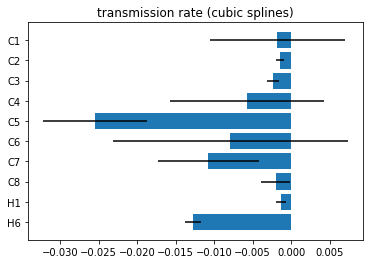

In [120]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order
plt.title('transmission rate (cubic splines)')
plt.show()

In [121]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [122]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


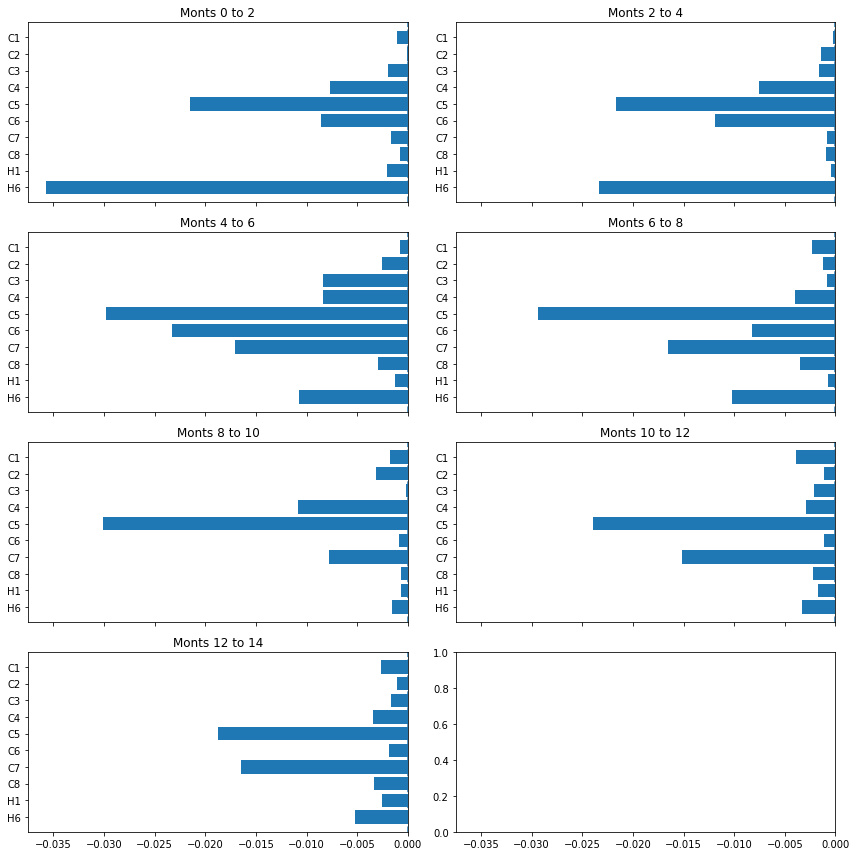

In [123]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
# fig.show()

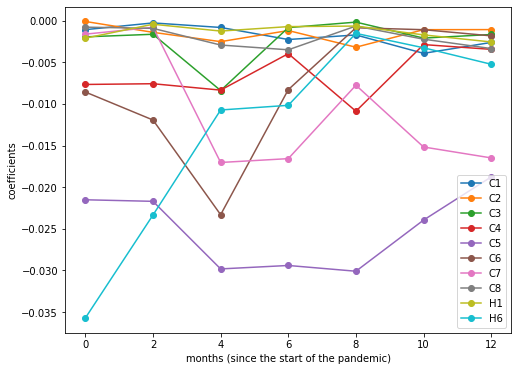

In [124]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

## Sub-regional policy implementation 

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [125]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [126]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [127]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [128]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [129]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [130]:
# repeat computation of labels for the new (sub)regions
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,0.095310,0.247127,0.000000,0.382992
2020-01-24,0.000000,0.058841,0.237200,0.000000,0.192372
2020-01-25,0.000000,0.097164,0.353038,0.000000,0.117783
2020-01-26,0.000000,0.200671,0.337818,0.000000,0.213574
2020-01-27,0.000000,0.087011,0.328822,0.000000,0.175891
...,...,...,...,...,...
2021-09-18,0.001659,0.002788,0.000632,0.005185,0.003252
2021-09-19,0.001791,0.002749,0.000581,0.006036,0.003097
2021-09-20,0.001101,0.001292,0.000281,0.002876,0.001531
2021-09-21,0.001203,0.001168,0.000298,0.002540,0.001139


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [131]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [132]:
def data_from_alt(iso, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [133]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Don't apply weights

In [134]:
r_sq = [initial_model_weighted(k, weighted=False)[3] for k in tot_dict.keys()]
print(np.asarray(r_sq).mean())
print(np.asarray(r_sq).var())

0.7898421977118244
0.01857792041436793


In [135]:
idx = -1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.048725
C3 : -0.002124
C4 : -0.067214
C6 : -0.008398
C7 : -0.040188
H6 : -0.038532
prev : 0.707964

R^2
---
0.962


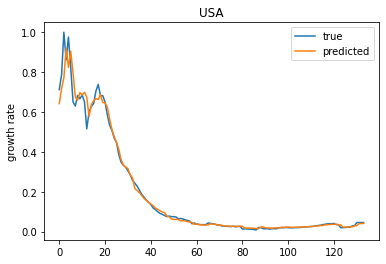

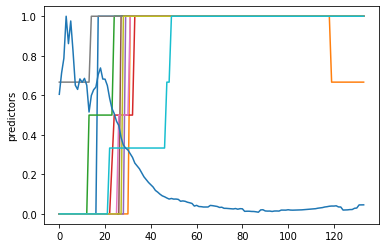

In [136]:
model, X, y = initial_model_weighted(cci, weighted=False)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [137]:
r_sq = [initial_model_weighted(k, weighted=True)[3] for k in tot_dict.keys()]
print(np.asarray(r_sq).mean())
print(np.asarray(r_sq).var())

0.814540097673022
0.012284150345675185


In [138]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.029380
C2 : -0.004219
C3 : -0.079420
C5 : -0.029839
C6 : -0.045047
C8 : -0.032774
H1 : 0.019894
H6 : -0.019239
prev : 0.698628

R^2
---
0.96


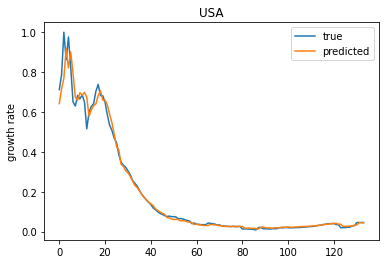

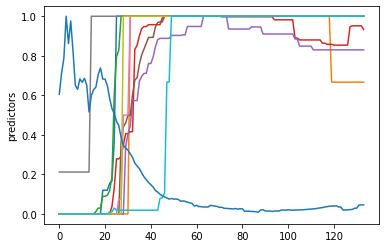

In [139]:
model, X, y = initial_model_weighted(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()